In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

In [6]:
df = pd.read_csv("loan_data.csv")
df.head(5)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [7]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [8]:
print(df.shape)
print(df.duplicated().sum())


(45000, 14)
0


In [9]:
categorical_cols = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
numeric_cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 
                'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']

# Fill missing categorical values
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill missing numeric values
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# -----------------------------
# Step 4: Encode categorical features
# -----------------------------
le = LabelEncoder()
for col in categorical_cols + ['loan_status']:
    df[col] = le.fit_transform(df[col])

# Ensure all data is numeric
df = df.apply(pd.to_numeric)

In [10]:
print("Skewness before transformation:\n", df[numeric_cols].skew())

Skewness before transformation:
 person_age                     2.548154
person_income                 34.137583
person_emp_exp                 2.594917
loan_amnt                      1.179731
loan_int_rate                  0.213784
loan_percent_income            1.034512
cb_person_cred_hist_length     1.631720
credit_score                  -0.610261
dtype: float64


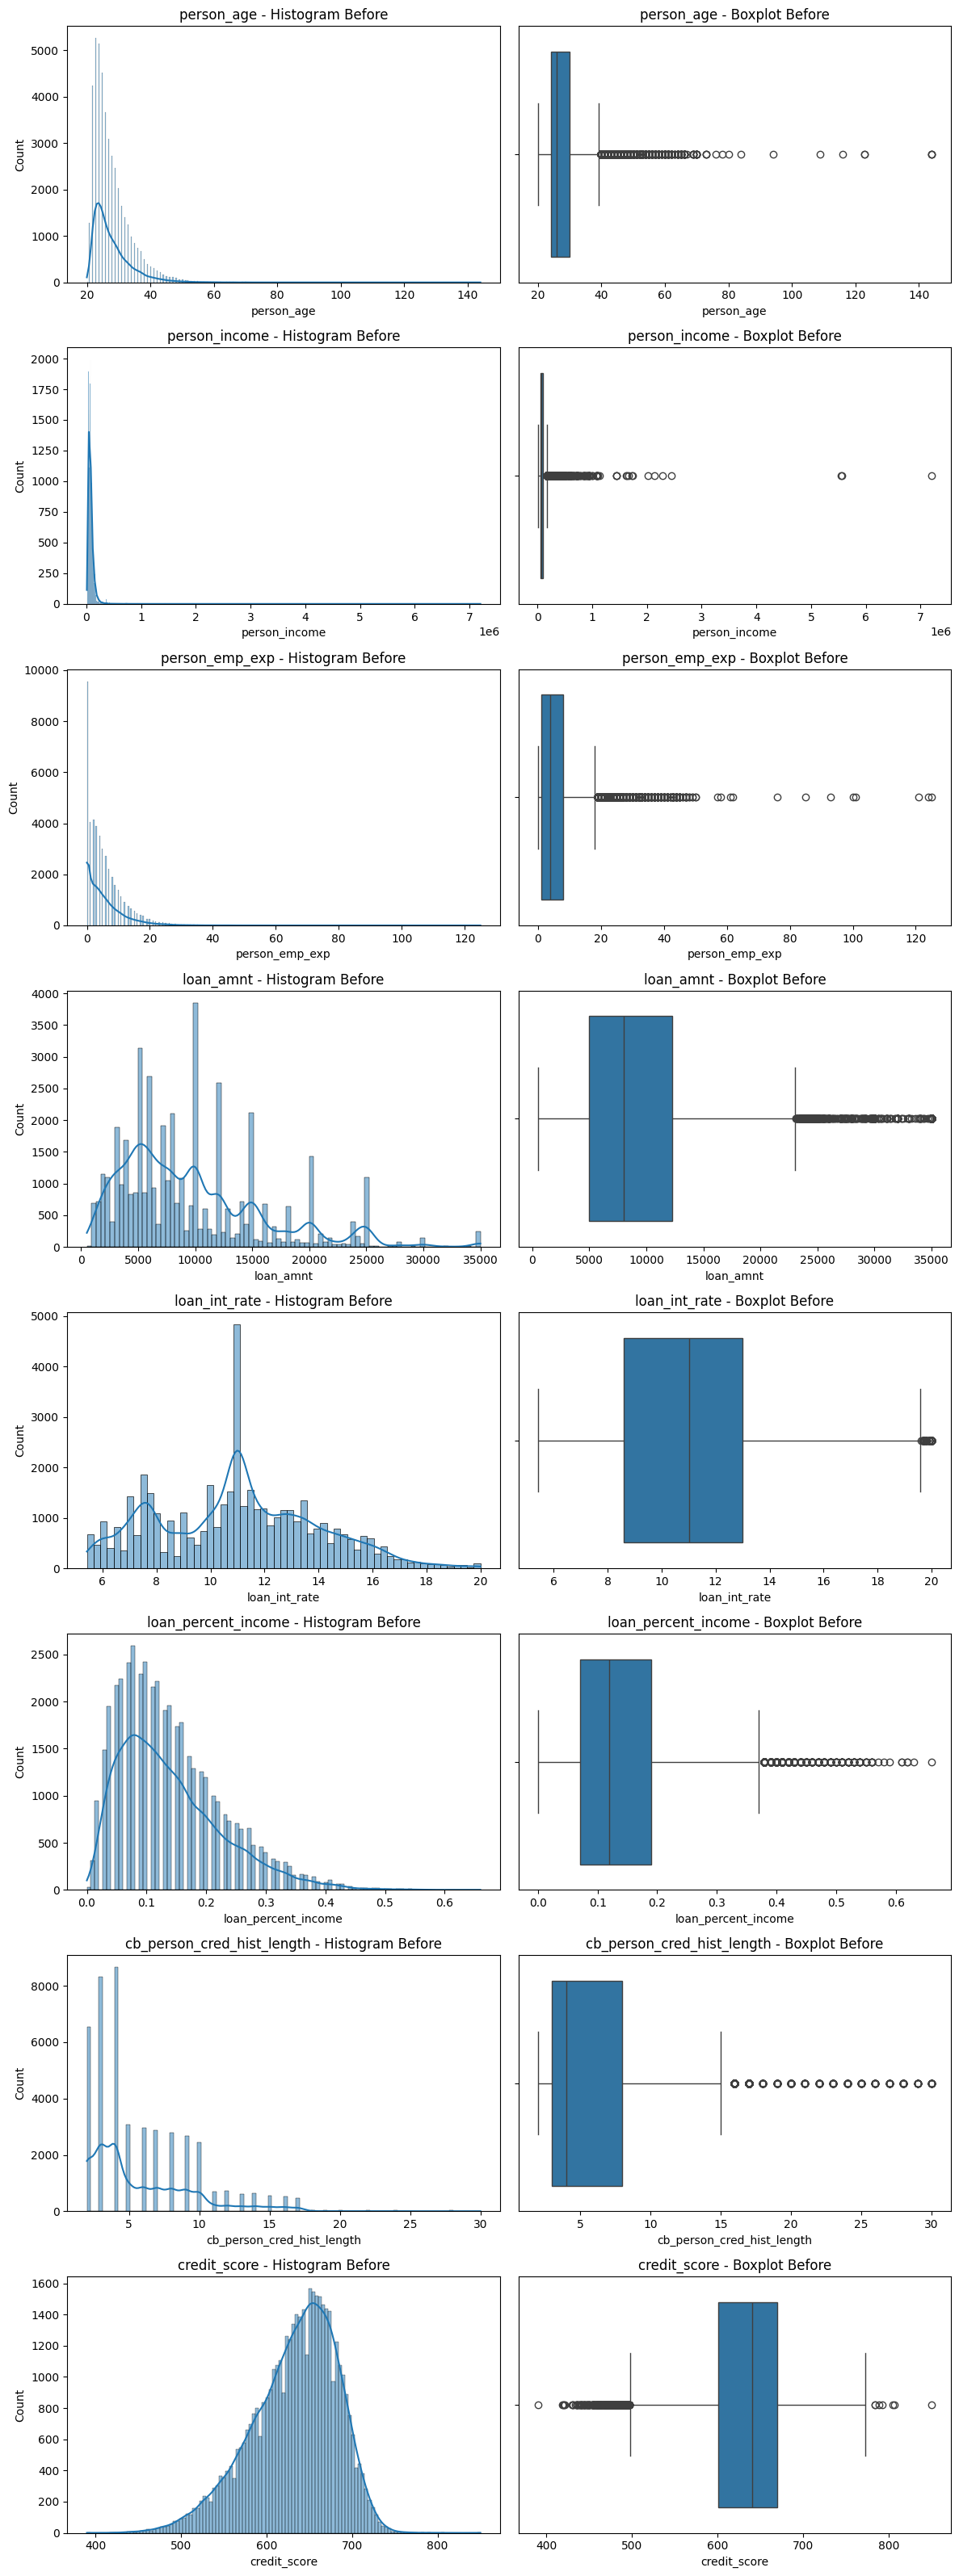

In [11]:
n = len(numeric_cols)
fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i,0])
    axes[i,0].set_title(f"{col} - Histogram Before")
    
    sns.boxplot(x=df[col], ax=axes[i,1])
    axes[i,1].set_title(f"{col} - Boxplot Before")

plt.tight_layout()
plt.show()

In [12]:
pt = PowerTransformer()
df[numeric_cols] = pt.fit_transform(df[numeric_cols])
print("Skewness after transformation:\n", df[numeric_cols].skew())

Skewness after transformation:
 person_age                    0.139352
person_income                -0.017895
person_emp_exp               -0.021322
loan_amnt                    -0.021640
loan_int_rate                -0.029283
loan_percent_income           0.091310
cb_person_cred_hist_length    0.073157
credit_score                 -0.044067
dtype: float64


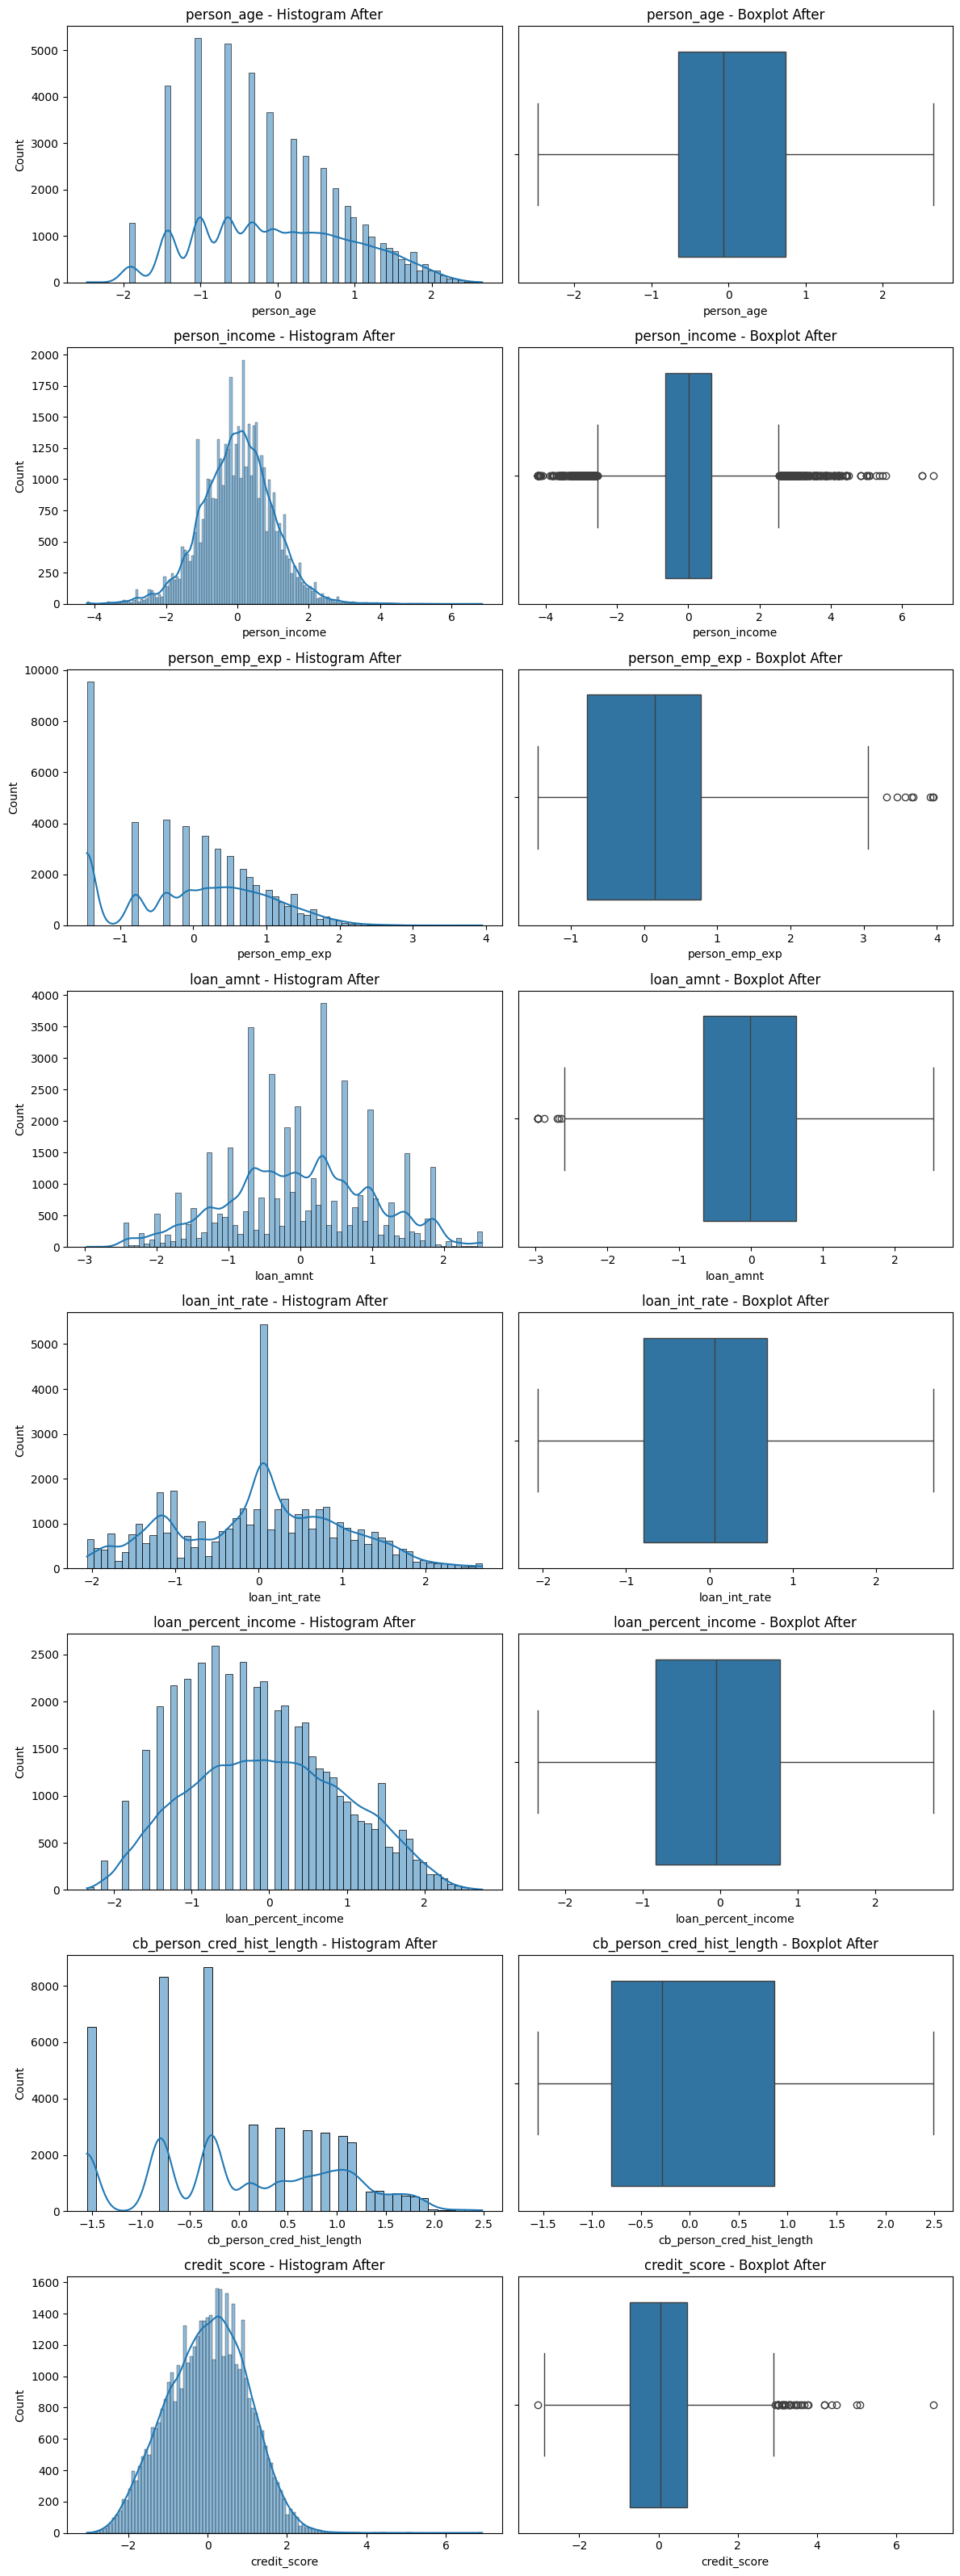

In [13]:
fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i,0])
    axes[i,0].set_title(f"{col} - Histogram After")
    
    sns.boxplot(x=df[col], ax=axes[i,1])
    axes[i,1].set_title(f"{col} - Boxplot After")

plt.tight_layout()
plt.show()

In [14]:

numeric_cols = ['person_age', 'person_income', 'person_emp_exp', 
                'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
                'cb_person_cred_hist_length', 'credit_score']

# Make a copy of original numeric data
numeric_original = df[numeric_cols].copy()

# Function to count outliers using IQR
def count_outliers(df, cols, factor=1.5):
    outlier_counts = {}
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < Q1 - factor*IQR) | (df[col] > Q3 + factor*IQR)]
        outlier_counts[col] = outliers.shape[0]
    return outlier_counts

# ===== Outliers BEFORE transformation =====
outliers_before = count_outliers(numeric_original, numeric_cols)

# ===== Apply Power Transformation =====
pt = PowerTransformer()
numeric_transformed = pd.DataFrame(pt.fit_transform(numeric_original), columns=numeric_cols)

# ===== Outliers AFTER transformation =====
outliers_after = count_outliers(numeric_transformed, numeric_cols)

# ===== Cap remaining outliers after transformation =====
for col in numeric_cols:
    Q1 = numeric_transformed[col].quantile(0.25)
    Q3 = numeric_transformed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    numeric_transformed[col] = numeric_transformed[col].clip(lower, upper)

# ===== Outliers AFTER transformation + capping =====
outliers_after_capping = count_outliers(numeric_transformed, numeric_cols)

# ===== Display results =====
outlier_table = pd.DataFrame({
    'Outliers Before Transformation': outliers_before,
    'Outliers After Transformation': outliers_after,
    'Outliers After Capping': outliers_after_capping
})

print("Outlier Counts Before and After Transformation + Capping:\n")
print(outlier_table)


Outlier Counts Before and After Transformation + Capping:

                            Outliers Before Transformation  \
person_age                                               0   
person_income                                          755   
person_emp_exp                                           8   
loan_amnt                                                9   
loan_int_rate                                            0   
loan_percent_income                                      0   
cb_person_cred_hist_length                               0   
credit_score                                            40   

                            Outliers After Transformation  \
person_age                                              0   
person_income                                         795   
person_emp_exp                                         10   
loan_amnt                                               9   
loan_int_rate                                           0   
loan_percent_inc

In [15]:

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Make sure all categorical columns are numeric
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Encode categorical variables (like gender, marital status, etc.)
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Encode target column if it's categorical
if y.dtypes == 'object':
    y = LabelEncoder().fit_transform(y)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check balance before SMOTE
print("Before SMOTE:")
print(y_train.value_counts())

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check balance after SMOTE
print("\nAfter SMOTE:")
print(y_train.value_counts())


Before SMOTE:
loan_status
0    28000
1     8000
Name: count, dtype: int64

After SMOTE:
loan_status
0    28000
1    28000
Name: count, dtype: int64


In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


Random Forest Metrics:
Accuracy: 0.915
Precision: 0.786809103576405
Recall: 0.847
F1 Score: 0.815795810257645


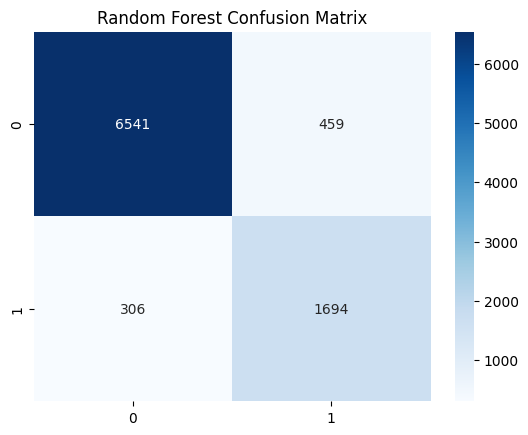

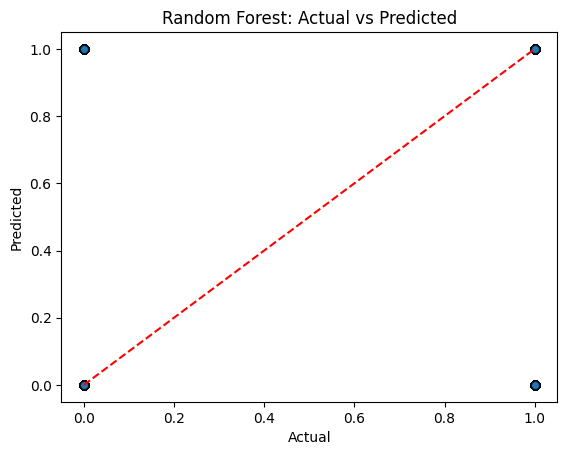

In [17]:
print("Random Forest Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

plt.scatter(y_test, y_pred_rf, alpha=0.6, edgecolors='k')
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted")
plt.show()


In [18]:
import pickle
with open("model.pkl", "wb") as f:
    pickle.dump({
        "model": rf,
        "label_encoders": label_encoders,
        "columns": X.columns.tolist()
    }, f)

print("✅ Model and encoders saved to model.pkl")

✅ Model and encoders saved to model.pkl
